In [1]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
# Setting GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
class CustomDataset(Dataset):
    def __init__(self):
        # Define the paths to your train and test directories
        self.train_dir = '/kaggle/input/dogs-vs-cats/train'
        self.test_dir = '/kaggle/input/dogs-vs-cats/test'

        # Data Augumentation
        train_transforms = transforms.Compose([
            transforms.CenterCrop(256), # Crop to center 256*256
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # ResNet Normalization parameters

            # You can perform more transformation
                # transforms.RandomResizedCrop(256),     
                # transforms.RandomHorizontalFlip(),
        ])
    
        test_transforms = transforms.Compose([
            transforms.Resize(256), # Resize shorter side to 256
            transforms.CenterCrop(256), # Then crop to 224x224
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        # Create the training dataset
        self.train_dataset = datasets.ImageFolder(root=self.train_dir, transform=train_transforms)
        
        # Create the testing dataset
        self.test_dataset = datasets.ImageFolder(root=self.test_dir, transform=test_transforms)

    def __len__(self):
        return len(self.train_dataset) + len(self.test_dataset)

    def __getitem__(self, index):
        return self.train_dataset[index]

> `train_dataset` output format - no. image | Channel | row | column

In [6]:
dataset = CustomDataset()

In [7]:
# Create the training dataloader
train_loader = DataLoader(
    dataset=dataset.train_dataset,
    batch_size=32,
    shuffle=True,  # Shuffle the training data at the beginning of each epoch
    num_workers=4,  # Use 4 worker processes to load data in parallel - max available till now
    pin_memory=True
)

# Create the testing dataloader
test_loader = DataLoader(
    dataset=dataset.test_dataset,
    batch_size=32,
    shuffle=False, # No need to shuffle the testing data
    num_workers=4,
    pin_memory=True
)

Class names: ['cats', 'dogs']
Class to index mapping: {'cats': 0, 'dogs': 1}

Shape of a batch of images: torch.Size([32, 3, 256, 256])
Shape of a batch of labels: torch.Size([32])


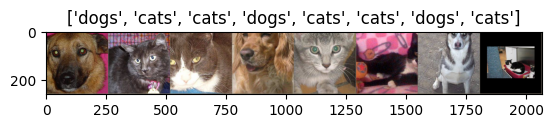

In [9]:
# Check the discovered classes and their indices
class_names = dataset.train_dataset.classes
print("Class names:", class_names)
print("Class to index mapping:", dataset.train_dataset.class_to_idx)

# Get one batch of training images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Print the shape of the tensors
print("\nShape of a batch of images:", images.shape) # Should be [batch_size, channels, height, width]
print("Shape of a batch of labels:", labels.shape)   # Should be [batch_size]

# --- Optional: Visualize a few images ---

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Make a grid from a batch
import torchvision
grid = torchvision.utils.make_grid(images[:8]) # Show first 8 images

# Get the corresponding labels
label_titles = [class_names[x] for x in labels[:8]]

# Display images
imshow(grid, title=label_titles)
plt.show()

In [10]:
class CustomModel(nn.Module):
    def __init__(self, in_channels):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(in_channels = in_channels, out_channels = 32, kernel_size = 3, padding = 'same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),

            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 'same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),

            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 'same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = 64*32*32, out_features = 256),
            
            nn.ReLU(),
            nn.Linear(in_features = 256, out_features = 128),
            nn.ReLU(),
            
            nn.Linear(in_features = 128, out_features = 64),
            nn.ReLU(),
            
            nn.Linear(in_features = 64, out_features = 32),
            nn.ReLU(),
            
            nn.Linear(in_features = 32, out_features = 16),
            nn.ReLU(),
            
            nn.Linear(in_features = 16, out_features = 8),
            nn.ReLU(),
            
            nn.Linear(in_features = 8, out_features = 1),
            nn.Sigmoid(),
        )

    def forward(self, X_train):
        model = self.features(X_train)
        model = self.classifier(model)
        return model

Excellent question. This gets to the core of how convolutional layers work in sequence. Let's clarify how the filters in your second `Conv2d` layer process the input they receive and what the final output dimension will be.

The input to your second convolutional layer is the output from the first block, which we established has the dimension: **`[32, Height / 2, Width / 2]`**.

The final output dimension after the entire second block of layers (`Conv2d`, `ReLU`, `MaxPool2d`) will be: **`[64, Height / 4, Width / 4]`**.

### Correcting a Key Concept: Filter Dimensions

You mentioned the filters being "3 dimention," which is a common point of confusion. Here’s a more precise explanation:

*   The input to this layer has **32 channels**.
*   Therefore, each of the **64 filters** in your second `Conv2d` layer must also have a depth of **32** to match the input.
*   If you use `kernel_size=3`, the actual shape of each of the 64 filters is not `3x3`, but **`32 x 3 x 3`** (Channels x Height x Width).

When this `32x3x3` filter is applied, it covers a `3x3` spatial area across all 32 input channels simultaneously, computing one final value for that position.

### Step-by-Step Dimension Calculation

Let's trace the data flow through your second block of layers, assuming a corrected and conventional `kernel_size=3`.

*   **Input Dimension**: `[32, Height / 2, Width / 2]`

#### 1. `nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same')`
*   **How it processes**: 64 different filters, each with a shape of `32x3x3`, slide over the input feature map. Each filter produces one output channel.
*   **Channels**: The `out_channels=64` parameter changes the depth from 32 to **64**.
*   **Height and Width**: `padding='same'` ensures the spatial dimensions do not change.
*   **Dimension after this layer**: `[64, Height / 2, Width / 2]`

#### 2. `nn.ReLU()`
*   The ReLU activation function is applied to each number in the tensor.
*   It **does not change the shape** of the tensor.
*   **Dimension after this layer**: `[64, Height / 2, Width / 2]`

#### 3. `nn.MaxPool2d(kernel_size=2, stride=2)`
*   This layer downsamples the feature map.
*   The `kernel_size=2` and `stride=2` combination **halves the height and width**.
*   (Height / 2) / 2 = **Height / 4**
*   (Width / 2) / 2 = **Width / 4**
*   **Dimension after this layer**: `[64, Height / 4, Width / 4]`

### Example with a `224x224` Image

Let's make this concrete with a `3x224x224` input image.

1.  **After the 1st block**, the dimension is ``.
2.  This `` tensor enters the **2nd block**.
3.  **After the 2nd `Conv2d` layer and `ReLU`**, the dimension becomes ``.
4.  **After the 2nd `MaxPool2d` layer**, the height and width are halved (112 / 2 = 56).
5.  **Final Output Dimension**: ``.

In [11]:
learning_rate = 0.01
epochs = 10

model = CustomModel(in_channels = 3)
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(params = model.parameters(), lr = learning_rate, betas=(0.9, 0.999))

In [12]:
for epoch in range(epochs):
    total_epoch_loss = 0
    for batch_features, batch_labels in train_loader:
        # Move the current batch to GPU
        X_train = batch_features.to(device)
        y_train = batch_labels.to(device)

        # Forward Propogation
        outputs = model(X_train)

        # Loss Calculation
        loss = criterion(outputs, y_train.float().view_as(outputs))

        # Backward Propogation
        optimizer.zero_grad()
        loss.backward()

        # Upgrad Gradients
        optimizer.step()

        # Loss Addition
        total_epoch_loss = total_epoch_loss + loss.item()

    avg_loss = total_epoch_loss / len(train_loader)
    print(f'Epoch: {epoch + 1} , Loss: {avg_loss}') 

Epoch: 1 , Loss: 0.6939132177352906
Epoch: 2 , Loss: 0.6935086936950684
Epoch: 3 , Loss: 0.6935121255874633
Epoch: 4 , Loss: 0.6934098703384399
Epoch: 5 , Loss: 0.6932474856376648
Epoch: 6 , Loss: 0.6934165863990783
Epoch: 7 , Loss: 0.6934084700584412
Epoch: 8 , Loss: 0.6933910733222961
Epoch: 9 , Loss: 0.6933156588554382
Epoch: 10 , Loss: 0.6933992540359497


NameError: name 'correct' is not defined

In [13]:
model.eval()

CustomModel(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=65536, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=64, bias=True)
    (6): ReLU()
    (7): Linear(in_features=64, out_features=32, bias=True)
    (8): ReLU()
    (9): Linear(in_features=32, out_features=16, bias=True

In [22]:
from torchmetrics.classification import BinaryAccuracy
# evaluation on test data
o = []
with torch.no_grad():
    
    for batch_features, batch_labels in test_loader:

        # move data to gpu
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
    
        outputs = model(batch_features)
    
        _, predicted = torch.max(outputs, 1)

        metric = BinaryAccuracy().to(device)
        o.append(metric(predicted, batch_labels))
sum(o) / len(o)

tensor(0.4976, device='cuda:0')